In [6]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import math
from torch.optim.lr_scheduler import ReduceLROnPlateau
import os
import pickle
import warnings
from sklearn.utils.class_weight import compute_sample_weight
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Create output directories
os.makedirs("models", exist_ok=True)
os.makedirs("plots", exist_ok=True)

# Function to load and preprocess data
def load_and_preprocess(file_path):
    df = pd.read_csv(file_path)
    print(f"Loading data from {file_path}")
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.set_index('timestamp')
    df = df.sort_index()
    df = df.fillna(method='ffill').fillna(method='bfill')
    
    # Smooth CPU utilization with rolling window
    for col in df.columns:
        if 'CPUUtilization' in col:
            df[col] = df[col].rolling(window=3, min_periods=1).mean()
    
    print(f"Shape after preprocessing: {df.shape}")
    return df

# Feature engineering
def add_features(df, service_type):
    print(f"Adding features for {service_type}...")
    
    if service_type == 'ec2':
        cpu_col = 'EC2_CPUUtilization'
        memory_col = 'EC2_MemoryUtilization'
        network_col = 'EC2_NetworkIn'
        disk_col = 'EC2_DiskWriteOps'
    elif service_type == 'rds':
        cpu_col = 'RDS_CPUUtilization'
        memory_col = 'RDS_FreeableMemory'
        conn_col = 'RDS_DatabaseConnections'
        io_col = 'RDS_WriteIOPS'
    elif service_type == 'ecs':
        cpu_col = 'ECS_CPUUtilization'
        memory_col = 'ECS_MemoryUtilization'
        task_col = 'ECS_RunningTaskCount'
        network_col = 'ECS_NetworkIn'
    
    # Original features
    original_columns = df.columns.tolist()
    
    # Add time-based features
    # Ensure the index is a DatetimeIndex
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)
    
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek
    df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
    df['is_business_hours'] = ((df['hour'] >= 9) & (df['hour'] < 17) & (df['is_weekend'] == 0)).astype(int)
    
    # Create utilization level categorical feature (will be one-hot encoded)
    # This helps the model distinguish between low, medium, and high utilization patterns
    def get_utilization_level(cpu):
        if cpu <= 20:
            return 0  # low
        elif cpu <= 70:
            return 1  # medium
        else:
            return 2  # high
    
    df['utilization_level'] = df[cpu_col].apply(get_utilization_level)
    df['is_low_utilization'] = (df['utilization_level'] == 0).astype(int)
    df['is_medium_utilization'] = (df['utilization_level'] == 1).astype(int)
    df['is_high_utilization'] = (df['utilization_level'] == 2).astype(int)
    
    # Add lag features
    for i in range(1, 4):
        df[f'{cpu_col}_lag_{i}'] = df[cpu_col].shift(i)

    # Add differencing features
    df[f'{cpu_col}_diff_1'] = df[cpu_col].diff(1)
    df[f'{cpu_col}_diff_3'] = df[cpu_col].diff(3)

    # Add rolling statistics - more fine-grained windows
    df[f'{cpu_col}_roll_mean_30m'] = df[cpu_col].rolling('30min', min_periods=1).mean()
    df[f'{cpu_col}_roll_mean_1h'] = df[cpu_col].rolling('1H', min_periods=1).mean()
    df[f'{cpu_col}_roll_std_1h'] = df[cpu_col].rolling('1H', min_periods=1).std().fillna(0)
    
    # Add rate of change features (acceleration/deceleration of CPU usage)
    df[f'{cpu_col}_roc_5m'] = df[cpu_col].pct_change(periods=1)
    df[f'{cpu_col}_roc_15m'] = df[cpu_col].pct_change(periods=3)
    
    # Service-specific features
    if service_type == 'ec2':
        df['EC2_CPU_Memory_Ratio'] = df[cpu_col] / (df[memory_col] + 1e-8)
        df['EC2_CPU_Network_Ratio'] = df[cpu_col] / (df[network_col] + 1e-8)
        df['EC2_CPU_Disk_Ratio'] = df[cpu_col] / (df[disk_col] + 1e-8)
        
        # New features for EC2
        df['EC2_is_high_memory'] = (df[memory_col] > 70).astype(int)
        df['EC2_memory_to_cpu_diff'] = df[memory_col] - df[cpu_col]
        
    elif service_type == 'rds':
        df['RDS_Memory_Usage_Estimate'] = 100 - (df[memory_col] / df[memory_col].max() * 100)
        df['RDS_CPU_Memory_Ratio'] = df[cpu_col] / (df['RDS_Memory_Usage_Estimate'] + 1e-8)
        df['RDS_CPU_Conn_Ratio'] = df[cpu_col] / (df[conn_col] + 1e-8)
        df['RDS_CPU_IO_Ratio'] = df[cpu_col] / (df[io_col] + 1e-8)
        
        # New features for RDS
        df['RDS_conn_per_cpu'] = df[conn_col] / (df[cpu_col] + 1e-8)
        df['RDS_io_intensive'] = (df[io_col] > df[io_col].quantile(0.75)).astype(int)
        
    elif service_type == 'ecs':
        df['ECS_CPU_Memory_Ratio'] = df[cpu_col] / (df[memory_col] + 1e-8)
        df['ECS_CPU_Task_Ratio'] = df[cpu_col] / (df[task_col] + 1e-8)
        df['ECS_CPU_Network_Ratio'] = df[cpu_col] / (df[network_col] + 1e-8)
        
        # New features for ECS
        df['ECS_per_task_cpu'] = df[cpu_col] / (df[task_col] + 1e-8)
        df['ECS_is_memory_bound'] = (df[memory_col] > df[cpu_col]).astype(int)
    
    # Cyclic encoding of time features (better than raw values for time)
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
    
    # Drop rows with NaN values (from lag features)
    original_len = len(df)
    df = df.dropna()
    print(f"Dropped {original_len - len(df)} rows containing NaN values")
    print(f"Shape after feature engineering: {df.shape}")
    
    # Save column names for later use
    new_columns = [col for col in df.columns if col not in original_columns and col != cpu_col]
    print(f"Added {len(new_columns)} new features")
    
    return df

# Custom weighted MSE loss
class WeightedMSELoss(nn.Module):
    def __init__(self, low_weight=3.0, med_weight=1.5, high_weight=1.0, threshold_low=20, threshold_high=70):
        super(WeightedMSELoss, self).__init__()
        self.low_weight = low_weight
        self.med_weight = med_weight 
        self.high_weight = high_weight
        self.threshold_low = threshold_low
        self.threshold_high = threshold_high
        
    def forward(self, predictions, targets, cpu_values=None):
        if cpu_values is None:
            # If CPU values aren't provided, use the target values
            cpu_values = targets
            
        # Calculate weights based on CPU values
        weights = torch.ones_like(cpu_values)
        weights = torch.where(cpu_values <= self.threshold_low, torch.tensor(self.low_weight).to(cpu_values.device), weights)
        weights = torch.where((cpu_values > self.threshold_low) & (cpu_values <= self.threshold_high), 
                              torch.tensor(self.med_weight).to(cpu_values.device), weights)
        
        # Calculate MSE
        squared_diff = (predictions - targets) ** 2
        
        # Apply weights
        weighted_squared_diff = squared_diff * weights
        
        # Return mean
        return weighted_squared_diff.mean()

# Dataset class
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y, original_values=None):
        self.X = X
        self.y = y
        self.original_values = original_values  # For weighted loss

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if self.original_values is not None:
            return self.X[idx], self.y[idx], self.original_values[idx]
        return self.X[idx], self.y[idx]

# Improved LSTM Model with residual connections and layer normalization
class EnhancedLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super(EnhancedLSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        
        # Layer normalization (helps training)
        self.layer_norm1 = nn.LayerNorm(hidden_size)
        
        # Attention mechanism
        self.attention = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.Tanh(),
            nn.Linear(hidden_size // 2, 1),
            nn.Softmax(dim=1)
        )
        
        # Fully connected layers with residual connection
        self.fc1 = nn.Linear(hidden_size, hidden_size // 2)
        self.fc2 = nn.Linear(hidden_size // 2, hidden_size // 2)
        self.fc3 = nn.Linear(hidden_size // 2, output_size)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate LSTM
        lstm_out, _ = self.lstm(x, (h0, c0))  # lstm_out: batch_size, seq_len, hidden_size
        
        # Apply layer normalization
        lstm_out = self.layer_norm1(lstm_out)
        
        # Attention mechanism
        attention_weights = self.attention(lstm_out)
        context = torch.sum(attention_weights * lstm_out, dim=1)
        
        # Fully connected layers with residual connection
        out = self.fc1(context)
        out = self.relu(out)
        out = self.dropout(out)
        
        residual = out
        out = self.fc2(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = out + residual  # Residual connection
        
        out = self.fc3(out)
        
        return out

# Data preparation with stratified sampling to ensure balanced utilization levels
def prepare_data_for_lstm(df, target_col, sequence_length=12):
    print(f"Preparing data with sequence length {sequence_length}...")
    
    # Extract target data
    target_data = df[target_col].values.reshape(-1, 1)
    
    # Keep original CPU values for weighted loss
    original_cpu_values = df[target_col].values
    
    # Identify utilization levels for stratified sampling
    utilization_levels = df['utilization_level'].values
    
    # Scale data
    feature_scaler = StandardScaler()
    target_scaler = StandardScaler()
    
    # Scale target
    scaled_target = target_scaler.fit_transform(target_data)
    
    # Scale features but keep target column unscaled for reference
    df_scaled = df.copy()
    df_scaled[target_col] = scaled_target.flatten()
    feature_columns = [col for col in df.columns if col != target_col]
    df_scaled[feature_columns] = feature_scaler.fit_transform(df[feature_columns])
    
    # Create sequences
    X, y, original_y, levels = [], [], [], []
    for i in range(len(df) - sequence_length):
        X.append(df_scaled.values[i:i+sequence_length, :])
        y.append(scaled_target[i+sequence_length])
        original_y.append(original_cpu_values[i+sequence_length])
        levels.append(utilization_levels[i+sequence_length])

    X = np.array(X)
    y = np.array(y)
    original_y = np.array(original_y)
    levels = np.array(levels)
    
    # Stratified split to ensure balanced representation of utilization levels
    X_train, X_val, y_train, y_val, original_y_train, original_y_val, levels_train, levels_val = train_test_split(
        X, y, original_y, levels, test_size=0.2, stratify=levels, random_state=42
    )
    
    # Convert to PyTorch tensors
    X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
    original_y_train = torch.tensor(original_y_train, dtype=torch.float32).reshape(-1, 1).to(device)
    
    X_val = torch.tensor(X_val, dtype=torch.float32).to(device)
    y_val = torch.tensor(y_val, dtype=torch.float32).to(device)
    original_y_val = torch.tensor(original_y_val, dtype=torch.float32).reshape(-1, 1).to(device)

    print(f"Training data shape: {X_train.shape}")
    print(f"Validation data shape: {X_val.shape}")
    
    # Distribution of utilization levels
    train_low = np.sum(levels_train == 0)
    train_med = np.sum(levels_train == 1)
    train_high = np.sum(levels_train == 2)
    print(f"Training data distribution - Low: {train_low} ({train_low/len(levels_train):.1%}), " + 
          f"Medium: {train_med} ({train_med/len(levels_train):.1%}), " + 
          f"High: {train_high} ({train_high/len(levels_train):.1%})")
    
    val_low = np.sum(levels_val == 0)
    val_med = np.sum(levels_val == 1)
    val_high = np.sum(levels_val == 2)
    print(f"Validation data distribution - Low: {val_low} ({val_low/len(levels_val):.1%}), " + 
          f"Medium: {val_med} ({val_med/len(levels_val):.1%}), " + 
          f"High: {val_high} ({val_high/len(levels_val):.1%})")
    
    all_columns = list(df_scaled.columns)
    
    return X_train, y_train, X_val, y_val, original_y_train, original_y_val, feature_scaler, target_scaler, all_columns

# Training function with weighted loss
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=100, patience=10, scheduler=None, use_weighted_loss=True):
    model.train()
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    best_model_state = None
    counter = 0
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        for data in train_loader:
            if use_weighted_loss and len(data) == 3:
                inputs, targets, original_targets = data
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, targets, original_targets)
            else:
                inputs, targets = data[:2]  # Take first two elements
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, targets)
            
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        
        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for data in val_loader:
                if use_weighted_loss and len(data) == 3:
                    inputs, targets, original_targets = data
                    outputs = model(inputs)
                    loss = criterion(outputs, targets, original_targets)
                else:
                    inputs, targets = data[:2]
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                
                val_loss += loss.item() * inputs.size(0)
        
        epoch_val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)
        
        # Learning rate scheduler
        if scheduler:
            scheduler.step(epoch_val_loss)
        
        # Early stopping
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_model_state = model.state_dict().copy()
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
        
        # Print progress
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}')
    
    # Load best model
    if best_model_state:
        model.load_state_dict(best_model_state)
    
    return model, train_losses, val_losses

# Evaluation function
def evaluate_model(model, test_loader, criterion, target_scaler, use_weighted_loss=True):
    model.eval()
    predictions = []
    actuals = []
    original_actuals = []
    test_loss = 0.0
    
    with torch.no_grad():
        for data in test_loader:
            if use_weighted_loss and len(data) == 3:
                inputs, targets, original_targets = data
                outputs = model(inputs)
                loss = criterion(outputs, targets, original_targets)
                original_actuals.extend(original_targets.cpu().numpy())
            else:
                inputs, targets = data[:2]
                outputs = model(inputs)
                loss = criterion(outputs, targets)
            
            test_loss += loss.item() * inputs.size(0)
            
            # Store predictions and actuals
            predictions.extend(outputs.cpu().numpy())
            actuals.extend(targets.cpu().numpy())
    
    avg_test_loss = test_loss / len(test_loader.dataset)
    
    # Convert to numpy arrays
    predictions = np.array(predictions)
    actuals = np.array(actuals)
    
    # Unscale the data
    predictions_unscaled = target_scaler.inverse_transform(predictions)
    actuals_unscaled = target_scaler.inverse_transform(actuals)
    
    # Ensure predictions don't exceed 100% CPU utilization or go below 0%
    predictions_unscaled = np.clip(predictions_unscaled, 0, 100)
    
    # Calculate metrics on unscaled data
    all_mae = np.mean(np.abs(predictions_unscaled - actuals_unscaled))
    all_rmse = np.sqrt(np.mean((predictions_unscaled - actuals_unscaled) ** 2))
    
    # Calculate metrics by utilization level
    low_mask = actuals_unscaled <= 20
    med_mask = (actuals_unscaled > 20) & (actuals_unscaled <= 70)
    high_mask = actuals_unscaled > 70
    
    low_mae = np.mean(np.abs(predictions_unscaled[low_mask] - actuals_unscaled[low_mask])) if np.any(low_mask) else 0
    med_mae = np.mean(np.abs(predictions_unscaled[med_mask] - actuals_unscaled[med_mask])) if np.any(med_mask) else 0
    high_mae = np.mean(np.abs(predictions_unscaled[high_mask] - actuals_unscaled[high_mask])) if np.any(high_mask) else 0
    
    print(f"Test Loss: {avg_test_loss:.4f}")
    print(f"Overall MAE: {all_mae:.4f}, RMSE: {all_rmse:.4f}")
    print(f"Low Utilization MAE: {low_mae:.4f} ({np.sum(low_mask)} samples)")
    print(f"Medium Utilization MAE: {med_mae:.4f} ({np.sum(med_mask)} samples)")
    print(f"High Utilization MAE: {high_mae:.4f} ({np.sum(high_mask)} samples)")
    
    detailed_metrics = {
        'mae': all_mae,
        'rmse': all_rmse,
        'low_mae': low_mae,
        'med_mae': med_mae,
        'high_mae': high_mae,
        'low_count': np.sum(low_mask),
        'med_count': np.sum(med_mask),
        'high_count': np.sum(high_mask)
    }
    
    return predictions_unscaled, actuals_unscaled, detailed_metrics

# Function to plot training results and predictions
def plot_results(train_losses, val_losses, predictions, actuals, metrics, service_name):
    plt.figure(figsize=(15, 10))
    
    # Plot training and validation loss
    plt.subplot(2, 1, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title(f'{service_name} - Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot predictions vs actuals
    plt.subplot(2, 1, 2)
    
    # Only plot a subset of points for clarity if there are many
    max_points = 500
    if len(predictions) > max_points:
        step = len(predictions) // max_points
        indices = range(0, len(predictions), step)
        plot_predictions = predictions.flatten()[indices]
        plot_actuals = actuals.flatten()[indices]
    else:
        plot_predictions = predictions.flatten()
        plot_actuals = actuals.flatten()
    
    plt.plot(plot_actuals, label='Actual', alpha=0.7)
    plt.plot(plot_predictions, label='Predicted', alpha=0.7)
    plt.title(f'{service_name} - Predictions vs Actuals\nMAE: {metrics["mae"]:.4f}, RMSE: {metrics["rmse"]:.4f}\n' +
              f'Low MAE: {metrics["low_mae"]:.4f}, Med MAE: {metrics["med_mae"]:.4f}, High MAE: {metrics["high_mae"]:.4f}')
    plt.xlabel('Sample')
    plt.ylabel('CPU Utilization (%)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Add a horizontal lines at 0% and 100% CPU
    plt.axhline(y=0, color='r', linestyle='--', alpha=0.3)
    plt.axhline(y=100, color='r', linestyle='--', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'plots/{service_name}_results.png')
    
    # Create a second plot for error analysis
    plt.figure(figsize=(15, 5))
    
    # Calculate errors
    errors = predictions.flatten() - actuals.flatten()
    
    # Plot error distribution
    plt.subplot(1, 2, 1)
    plt.hist(errors, bins=50, alpha=0.75)
    plt.axvline(x=0, color='r', linestyle='--')
    plt.title(f'{service_name} - Error Distribution')
    plt.xlabel('Prediction Error')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)
    
    # Plot predictions vs actuals as scatter plot
    plt.subplot(1, 2, 2)
    
    # Color points by utilization level
    colors = np.zeros_like(actuals.flatten(), dtype=int)
    colors[actuals.flatten() <= 20] = 0  # Low - blue
    colors[(actuals.flatten() > 20) & (actuals.flatten() <= 70)] = 1  # Medium - green
    colors[actuals.flatten() > 70] = 2  # High - red
    
    cmap = plt.cm.get_cmap('viridis', 3)
    scatter = plt.scatter(actuals.flatten(), predictions.flatten(), c=colors, cmap=cmap, alpha=0.3)
    
    plt.plot([0, 100], [0, 100], 'r--')  # Perfect prediction line
    plt.title(f'{service_name} - Predicted vs Actual')
    plt.xlabel('Actual CPU Utilization (%)')
    plt.ylabel('Predicted CPU Utilization (%)')
    plt.xlim(0, 100)
    plt.ylim(0, 100)
    plt.grid(True, alpha=0.3)
    
    # Add legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(0), markersize=10, label='Low Utilization'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(1), markersize=10, label='Medium Utilization'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(2), markersize=10, label='High Utilization')
    ]
    plt.legend(handles=legend_elements)
    
    plt.tight_layout()
    plt.savefig(f'plots/{service_name}_error_analysis.png')

# Function to test predictions at different utilization levels
def test_model_at_different_levels(model, feature_scaler, target_scaler, df, target_col, sequence_length):
    # Prepare data
    df_scaled = df.copy()
    
    # Create copies of the dataset for each level
    df_low = df.copy()
    df_medium = df.copy()
    df_high = df.copy()
    
    # Set target column to different utilization levels
    df_low[target_col] = df_low[target_col].apply(lambda x: min(20, x))  # Set to low (0-20%)
    df_medium[target_col] = df_medium[target_col].apply(lambda x: min(60, max(40, x)))  # Set to medium (40-60%)
    df_high[target_col] = df_high[target_col].apply(lambda x: max(80, x))  # Set to high (80-100%)
    
    # Update feature engineering based on new target values
    service_type = 'ec2' if 'EC2' in target_col else 'rds' if 'RDS' in target_col else 'ecs'
    
    df_low = add_features(df_low, service_type)
    df_medium = add_features(df_medium, service_type)
    df_high = add_features(df_high, service_type)
    
    results = {}
    
    # Test on each level
    for level, df_test in [('low', df_low), ('medium', df_medium), ('high', df_high)]:
        print(f"\nTesting on {level} utilization...")
        
        # Scale features
        feature_columns = list(df_test.columns)
        if target_col in feature_columns:
            feature_columns.remove(target_col)
        
        df_test_scaled = df_test.copy()
        df_test_scaled[feature_columns] = feature_scaler.transform(df_test[feature_columns])
        
        # Prepare sequences
        X_sequences = []
        y_actual = []
        
        for i in range(min(100, len(df_test) - sequence_length)):  # Limit to 100 samples for testing
            X_sequences.append(df_test_scaled.values[i:i+sequence_length, :])
            y_actual.append(df_test[target_col].values[i+sequence_length])
        
        X_sequences = np.array(X_sequences)
        X_sequences_tensor = torch.tensor(X_sequences, dtype=torch.float32).to(device)
        
        # Make predictions
        model.eval()
        with torch.no_grad():
            predictions_scaled = model(X_sequences_tensor).cpu().numpy()
        
        # Inverse transform predictions and clip to valid range
        predictions = target_scaler.inverse_transform(predictions_scaled)
        predictions = np.clip(predictions, 0, 100)  # Ensure predictions are between 0 and 100%
        
        # Calculate errors
        y_actual = np.array(y_actual).reshape(-1, 1)
        errors = np.abs(predictions - y_actual)
        
        avg_error = np.mean(errors)
        max_error = np.max(errors)
        
        # Calculate percentage errors
        percentage_errors = (errors / np.maximum(y_actual, 1e-8)) * 100
        avg_percentage_error = np.mean(percentage_errors)
        max_percentage_error = np.max(percentage_errors)
        
        results[level] = {
            'avg_error': avg_error,
            'max_error': max_error,
            'avg_percentage_error': avg_percentage_error,
            'max_percentage_error': max_percentage_error
        }
        
        print(f"Average error: {avg_error:.2f}%, Max error: {max_error:.2f}%")
        print(f"Average percentage error: {avg_percentage_error:.2f}%, Max percentage error: {max_percentage_error:.2f}%")
    
    return results

# Main pipeline function with enhanced features
def run_lstm_pipeline(data_path, service_type, target_col):
    print(f"\n{'-'*50}")
    print(f"Processing {service_type.upper()} data")
    print(f"{'-'*50}")
    
    try:
        # Load and preprocess data
        df = load_and_preprocess(data_path)
        
        # Add features with enhanced engineering
        df = add_features(df, service_type)
        
        # Print low, medium, high distribution
        if 'CPUUtilization' in target_col:
            low = len(df[df[target_col] <= 20])
            medium = len(df[(df[target_col] > 20) & (df[target_col] <= 70)])
            high = len(df[df[target_col] > 70])
            total = len(df)
            
            print(f"Data distribution:")
            print(f"  Low CPU (0-20%): {low} samples ({low/total*100:.1f}%)")
            print(f"  Medium CPU (20-70%): {medium} samples ({medium/total*100:.1f}%)")
            print(f"  High CPU (70-100%): {high} samples ({high/total*100:.1f}%)")
        
        # Prepare data for LSTM with balanced sampling
        sequence_length = 12  # 1 hour at 5-min intervals
        X_train, y_train, X_val, y_val, original_y_train, original_y_val, feature_scaler, target_scaler, all_columns = prepare_data_for_lstm(
            df, target_col, sequence_length)
        
        # Create dataloaders with original CPU values for weighted loss
        train_dataset = TimeSeriesDataset(X_train, y_train, original_y_train)
        val_dataset = TimeSeriesDataset(X_val, y_val, original_y_val)
        
        batch_size = 64
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size)
        
        # Create enhanced model
        input_size = X_train.shape[2]  # Number of features
        hidden_size = 64  # More compact model to reduce overfitting
        num_layers = 2   # Fewer layers to reduce overfitting
        output_size = 1
        dropout_rate = 0.3
        
        model = EnhancedLSTMModel(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            output_size=output_size,
            dropout=dropout_rate
        ).to(device)
        
        # Print model info
        print(f"\nModel architecture:")
        print(f"  Enhanced LSTM with attention and residual connections")
        print(f"  Input size: {input_size}")
        print(f"  Hidden size: {hidden_size}")
        print(f"  Number of layers: {num_layers}")
        print(f"  Dropout rate: {dropout_rate}")
        
        # Weighted loss function - emphasize low CPU values
        criterion = WeightedMSELoss(low_weight=5.0, med_weight=2.0, high_weight=1.0)
        
        # Optimizer with weight decay to prevent overfitting
        optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
        
        # Learning rate scheduler
        scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=5, verbose=True)
        
        # Train model
        print(f"\nTraining {service_type.upper()} LSTM model...")
        num_epochs = 100
        patience = 15
        model, train_losses, val_losses = train_model(
            model, train_loader, val_loader, criterion, optimizer, 
            num_epochs=num_epochs, patience=patience, scheduler=scheduler,
            use_weighted_loss=True
        )
        
        # Evaluate model
        print(f"\nEvaluating {service_type.upper()} LSTM model...")
        predictions, actuals, metrics = evaluate_model(model, val_loader, criterion, target_scaler, use_weighted_loss=True)
        
        # Test model at different utilization levels
        level_results = test_model_at_different_levels(
            model, feature_scaler, target_scaler, df, target_col, sequence_length
        )
        
        # Plot results
        plot_results(train_losses, val_losses, predictions, actuals, metrics, service_type)
        
        # Save model and scalers
        model_data = {
            'model_state_dict': model.state_dict(),
            'input_size': input_size,
            'hidden_size': hidden_size,
            'num_layers': num_layers,
            'sequence_length': sequence_length,
            'feature_scaler': feature_scaler,
            'target_scaler': target_scaler,
            'all_columns': all_columns,
            'metrics': metrics,
            'level_results': level_results
        }
        
        torch.save(model_data, f'models/{service_type}_lstm_model_enhanced.pth')
        print(f"{service_type.upper()} model saved as models/{service_type}_lstm_model_enhanced.pth")
        
        # Additional plot: Training loss vs utilization level performance
        plt.figure(figsize=(10, 6))
        plt.plot(train_losses, label='Training Loss')
        plt.plot(val_losses, label='Validation Loss')
        
        # Add horizontal lines for MAE by utilization level
        plt.axhline(y=metrics['low_mae'], color='blue', linestyle='--', label=f'Low Util. MAE: {metrics["low_mae"]:.2f}')
        plt.axhline(y=metrics['med_mae'], color='green', linestyle='--', label=f'Medium Util. MAE: {metrics["med_mae"]:.2f}')
        plt.axhline(y=metrics['high_mae'], color='red', linestyle='--', label=f'High Util. MAE: {metrics["high_mae"]:.2f}')
        
        plt.title(f'{service_type.upper()} - Training Progress and Performance by Utilization Level')
        plt.xlabel('Epochs')
        plt.ylabel('Loss / MAE')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.savefig(f'plots/{service_type}_training_by_utilization.png')
        
        return model, (feature_scaler, target_scaler), metrics, level_results
    
    except Exception as e:
        import traceback
        print(f"ERROR processing {service_type}: {str(e)}")
        print(traceback.format_exc())
        return None, None, None, None

# Function to generate synthetic data for under-represented ranges
def augment_data_for_low_utilization(df, target_col, num_samples=1000):
    """
    Generate synthetic data points specifically for low CPU utilization ranges
    where the model tends to perform poorly
    """
    print(f"Augmenting data with {num_samples} synthetic low-utilization samples...")
    
    # Copy the original dataframe
    df_original = df.copy()
    
    # Get service type
    service_type = 'ec2' if 'EC2' in target_col else 'rds' if 'RDS' in target_col else 'ecs'
    
    # Create a new dataframe for synthetic data
    low_samples = []
    
    # Get low utilization samples as templates
    low_df = df[df[target_col] <= 20].copy()
    
    if len(low_df) < 10:
        print("Not enough low utilization samples to use as templates. Using random samples instead.")
        low_df = df.sample(min(100, len(df)))
    
    # Generate synthetic samples based on low utilization templates
    for _ in range(num_samples):
        # Pick a random low utilization sample
        template = low_df.sample(1)
        
        # Create a synthetic sample with small random variations
        synthetic = template.copy()
        
        # Set CPU utilization to a random low value (0-20%)
        synthetic[target_col] = np.random.uniform(1, 20)
        
        # Add random noise to other features (but keep within reasonable bounds)
        for col in synthetic.columns:
            if col != target_col and col != 'timestamp' and not col.startswith('utilization_level'):
                # Add up to ±20% noise to numerical columns
                if synthetic[col].dtype in [np.int64, np.float64]:
                    noise_factor = np.random.uniform(0.8, 1.2)
                    synthetic[col] = synthetic[col] * noise_factor
        
        low_samples.append(synthetic)
    
    # Concatenate synthetic samples
    df_synthetic = pd.concat(low_samples)
    
    # Reset index
    df_synthetic = df_synthetic.reset_index(drop=True)
    
    # Combine original and synthetic data
    df_augmented = pd.concat([df_original, df_synthetic])
    
    # Reset index
    df_augmented = df_augmented.reset_index(drop=True)
    
    # Print distribution after augmentation
    low = len(df_augmented[df_augmented[target_col] <= 20])
    medium = len(df_augmented[(df_augmented[target_col] > 20) & (df_augmented[target_col] <= 70)])
    high = len(df_augmented[df_augmented[target_col] > 70])
    total = len(df_augmented)
    
    print(f"Data distribution after augmentation:")
    print(f"  Low CPU (0-20%): {low} samples ({low/total*100:.1f}%)")
    print(f"  Medium CPU (20-70%): {medium} samples ({medium/total*100:.1f}%)")
    print(f"  High CPU (70-100%): {high} samples ({high/total*100:.1f}%)")
    
    return df_augmented

# Main execution
if __name__ == "__main__":
    # Define services to process
    services = [
        {'file': '../dataset scripts/ec2_metrics.csv', 'type': 'ec2', 'target': 'EC2_CPUUtilization'},
        {'file': '../dataset scripts/rds_metrics.csv', 'type': 'rds', 'target': 'RDS_CPUUtilization'},
        {'file': '../dataset scripts/ecs_metrics.csv', 'type': 'ecs', 'target': 'ECS_CPUUtilization'}
    ]
    
    results = {}
    
    for service in services:
        print(f"\n{'='*50}")
        print(f"Processing {service['type'].upper()} service")
        print(f"{'='*50}")
        
        # Load and preprocess data
        df = load_and_preprocess(service['file'])
        
        # Check if low utilization samples are underrepresented
        low = len(df[df[service['target']] <= 20])
        total = len(df)
        low_percentage = low / total * 100
        
        # If less than 30% of data is low utilization, augment it
        if low_percentage < 30:
            print(f"Low utilization samples are underrepresented ({low_percentage:.1f}%). Augmenting data...")
            # Calculate how many samples to add to reach approximately 33% low utilization
            num_samples_to_add = max(0, int((total * 0.5) - low))
            df = augment_data_for_low_utilization(df, service['target'], num_samples=num_samples_to_add)
        
        # Add features
        df = add_features(df, service['type'])
        
        # Run pipeline with augmented data
        model, scalers, metrics, level_results = run_lstm_pipeline(
            service['file'], service['type'], service['target']
        )
        
        if model is not None:
            results[service['type']] = {
                'metrics': metrics,
                'level_results': level_results
            }
    
    # Print summary of results
    print("\n\n" + "="*50)
    print("SUMMARY OF RESULTS")
    print("="*50)
    
    for service_type, result in results.items():
        print(f"\n{service_type.upper()} Model:")
        print(f"  Overall - MAE: {result['metrics']['mae']:.4f}, RMSE: {result['metrics']['rmse']:.4f}")
        print(f"  Low Util. MAE: {result['metrics']['low_mae']:.4f} ({result['metrics']['low_count']} samples)")
        print(f"  Medium Util. MAE: {result['metrics']['med_mae']:.4f} ({result['metrics']['med_count']} samples)")
        print(f"  High Util. MAE: {result['metrics']['high_mae']:.4f} ({result['metrics']['high_count']} samples)")
        
        for level, level_metrics in result['level_results'].items():
            print(f"  {level.capitalize()} utilization test - Avg Error: {level_metrics['avg_error']:.4f}, Max Error: {level_metrics['max_error']:.4f}")
    
    # Create comparative visualization
    plt.figure(figsize=(15, 10))
    
    # Prepare data for bar chart
    service_names = list(results.keys())
    low_mae = [results[s]['metrics']['low_mae'] for s in service_names]
    med_mae = [results[s]['metrics']['med_mae'] for s in service_names]
    high_mae = [results[s]['metrics']['high_mae'] for s in service_names]
    
    x = np.arange(len(service_names))
    width = 0.25
    
    plt.subplot(2, 1, 1)
    plt.bar(x - width, low_mae, width, label='Low Utilization', color='blue')
    plt.bar(x, med_mae, width, label='Medium Utilization', color='green')
    plt.bar(x + width, high_mae, width, label='High Utilization', color='red')
    
    plt.xlabel('Service')
    plt.ylabel('Mean Absolute Error')
    plt.title('Model Performance by Utilization Level')
    plt.xticks(x, [s.upper() for s in service_names])
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Sample distribution
    plt.subplot(2, 1, 2)
    for i, service_type in enumerate(service_names):
        low_count = results[service_type]['metrics']['low_count']
        med_count = results[service_type]['metrics']['med_count']
        high_count = results[service_type]['metrics']['high_count']
        total = low_count + med_count + high_count
        
        plt.bar(i-width, low_count/total*100, width, label='Low' if i==0 else "", color='blue')
        plt.bar(i, med_count/total*100, width, label='Medium' if i==0 else "", color='green')
        plt.bar(i+width, high_count/total*100, width, label='High' if i==0 else "", color='red')
    
    plt.xlabel('Service')
    plt.ylabel('Percentage of Samples')
    plt.title('Data Distribution by Utilization Level')
    plt.xticks(x, [s.upper() for s in service_names])
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('plots/comparative_results.png')
    
    print("\nAll models trained and evaluated. Results saved to the 'models' and 'plots' directories.")

Using device: cpu

Processing EC2 service
Loading data from ../dataset scripts/ec2_metrics.csv
Shape after preprocessing: (43200, 4)
Low utilization samples are underrepresented (8.6%). Augmenting data...
Augmenting data with 17886 synthetic low-utilization samples...
Data distribution after augmentation:
  Low CPU (0-20%): 21600 samples (35.4%)
  Medium CPU (20-70%): 36648 samples (60.0%)
  High CPU (70-100%): 2838 samples (4.6%)
Adding features for ec2...
Dropped 3 rows containing NaN values
Shape after feature engineering: (61083, 31)
Added 27 new features

--------------------------------------------------
Processing EC2 data
--------------------------------------------------
Loading data from ../dataset scripts/ec2_metrics.csv
Shape after preprocessing: (43200, 4)
Adding features for ec2...
Dropped 3 rows containing NaN values
Shape after feature engineering: (43197, 31)
Added 27 new features
Data distribution:
  Low CPU (0-20%): 3714 samples (8.6%)
  Medium CPU (20-70%): 36645 sa

: 

Testing

Testing LSTM models for EC2, RDS, and ECS across different usage levels...

Testing EC2 model...
Loaded ec2 model with input size 22, sequence length 12
  Testing low usage scenario...
Generating test data for ec2 at low usage level
Error testing ec2 model: X has 22 features, but StandardScaler is expecting 21 features as input.
Traceback (most recent call last):
  File "/var/folders/8f/t4rh2kc96bdfdg29x5rscwmw0000gn/T/ipykernel_93153/2041133592.py", line 239, in test_models
    predicted_cpu = predict_cpu_utilization(model, feature_scaler, target_scaler, df)
  File "/var/folders/8f/t4rh2kc96bdfdg29x5rscwmw0000gn/T/ipykernel_93153/2041133592.py", line 199, in predict_cpu_utilization
    df_scaled = feature_scaler.transform(df.values)
  File "/Users/hwimalasooriya/Documents/GitHub/Intelligent-resource-management-system-POC-/model_venv/lib/python3.10/site-packages/sklearn/utils/_set_output.py", line 319, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "/Users/hwimalasoor

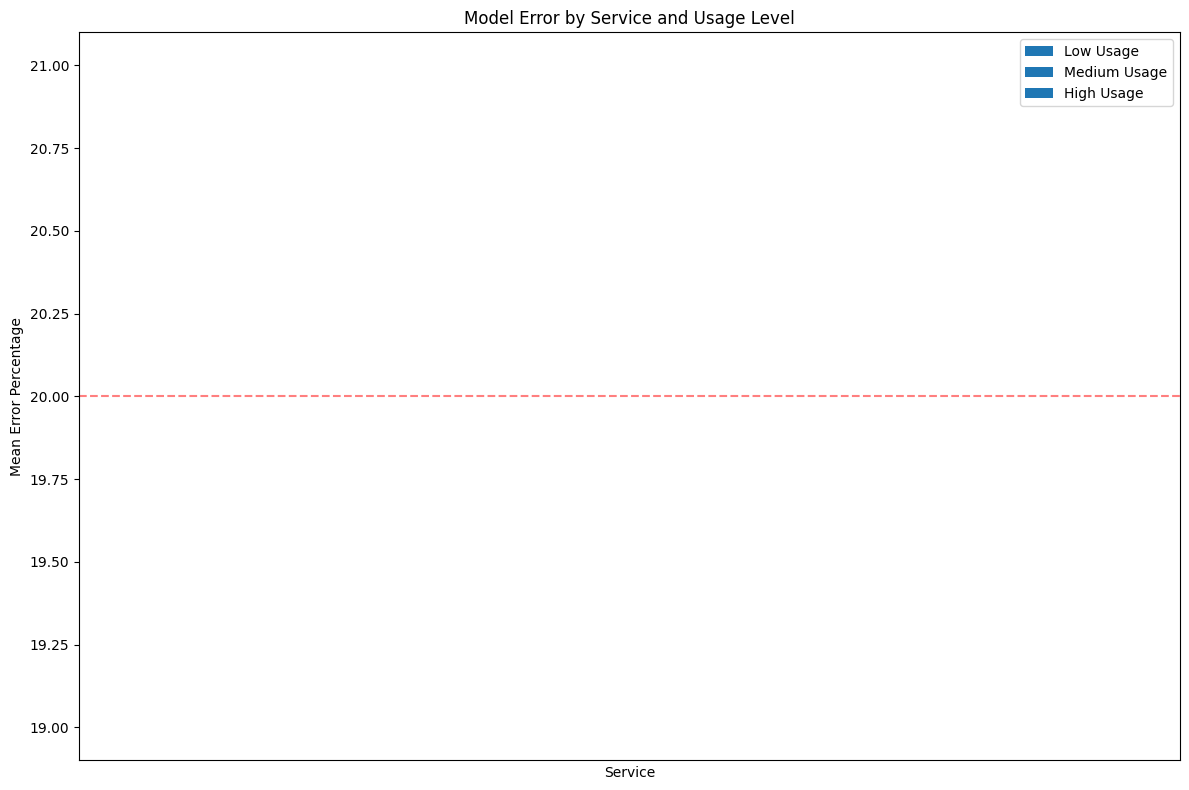

<Figure size 1500x500 with 0 Axes>

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import os
import pandas as pd
from datetime import datetime, timedelta
import json
import traceback

# Create output directory
os.makedirs("test_results", exist_ok=True)

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Define the Enhanced LSTM Model with attention and residual connections
class EnhancedLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super(EnhancedLSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        
        # Layer normalization
        self.layer_norm1 = nn.LayerNorm(hidden_size)
        
        # Attention mechanism
        self.attention = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.Tanh(),
            nn.Linear(hidden_size // 2, 1),
            nn.Softmax(dim=1)
        )
        
        # Fully connected layers with residual connection
        self.fc1 = nn.Linear(hidden_size, hidden_size // 2)
        self.fc2 = nn.Linear(hidden_size // 2, hidden_size // 2)
        self.fc3 = nn.Linear(hidden_size // 2, output_size)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        # Make sure x is 3D [batch_size, sequence_length, input_size]
        if len(x.size()) == 2:
            x = x.unsqueeze(0)  # Add batch dimension if missing
            
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate LSTM
        lstm_out, _ = self.lstm(x, (h0, c0))  # lstm_out: batch_size, seq_len, hidden_size
        
        # Apply layer normalization
        lstm_out = self.layer_norm1(lstm_out)
        
        # Attention mechanism
        attention_weights = self.attention(lstm_out)
        context = torch.sum(attention_weights * lstm_out, dim=1)
        
        # Fully connected layers with residual connection
        out = self.fc1(context)
        out = self.relu(out)
        out = self.dropout(out)
        
        residual = out
        out = self.fc2(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = out + residual  # Residual connection
        
        out = self.fc3(out)
        
        return out

# Load models and scalers
def load_model(service_type):
    device = torch.device("cpu")  # Use CPU for simplicity
    
    try:
        # Try to load enhanced model first
        model_path = f'models/{service_type}_lstm_model_enhanced.pth'
        if not os.path.exists(model_path):
            # Fall back to regular model
            model_path = f'models/{service_type}_lstm_model.pth'
            
        print(f"Loading model from {model_path}")
        checkpoint = torch.load(model_path, map_location=device)
        
        # Create model instance
        input_size = checkpoint['input_size']
        hidden_size = checkpoint['hidden_size']
        num_layers = checkpoint['num_layers']
        sequence_length = checkpoint['sequence_length']
        
        model = EnhancedLSTMModel(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            output_size=1,
            dropout=0.3
        )
        
        model.load_state_dict(checkpoint['model_state_dict'])
        model.eval()
        
        # Get scalers and column info
        feature_scaler = checkpoint['feature_scaler']
        target_scaler = checkpoint['target_scaler']
        all_columns = checkpoint.get('all_columns', None)
        
        print(f"Loaded {service_type} model with input size {input_size}, hidden size {hidden_size}, sequence length {sequence_length}")
        
        return model, feature_scaler, target_scaler, sequence_length, all_columns
    except Exception as e:
        print(f"Error loading model: {str(e)}")
        print(traceback.format_exc())
        return None, None, None, None, None

# Generate synthetic test data for different resource usage levels
def generate_test_data(service_type, usage_level, sequence_length, all_columns=None):
    """Generate synthetic test data with consistent features across all models"""
    print(f"Generating test data for {service_type} at {usage_level} usage level")
    
    # Set base CPU level based on usage scenario
    if usage_level == "low":
        base_cpu = np.random.uniform(5, 15)  # 5-15% CPU usage
    elif usage_level == "medium":
        base_cpu = np.random.uniform(40, 60)  # 40-60% CPU usage
    else:  # high
        base_cpu = np.random.uniform(80, 95)  # 80-95% CPU usage
    
    # Create timestamps for the sequence
    end_time = datetime.now()
    timestamps = [end_time - timedelta(minutes=5*i) for i in range(sequence_length)]
    timestamps.reverse()  # Sort in ascending order
    
    # Initialize DataFrame with timestamps
    df = pd.DataFrame(index=timestamps)
    df.index.name = 'timestamp'
    
    # Get the CPU column name
    if service_type == 'ec2':
        cpu_col = 'EC2_CPUUtilization'
        memory_col = 'EC2_MemoryUtilization'
        disk_col = 'EC2_DiskWriteOps'
        network_col = 'EC2_NetworkIn'
    elif service_type == 'rds':
        cpu_col = 'RDS_CPUUtilization'
        memory_col = 'RDS_FreeableMemory'
        conn_col = 'RDS_DatabaseConnections'
        io_col = 'RDS_WriteIOPS'
    else:  # ecs
        cpu_col = 'ECS_CPUUtilization'
        memory_col = 'ECS_MemoryUtilization'
        task_col = 'ECS_RunningTaskCount'
        network_col = 'ECS_NetworkIn'
    
    # Generate base metrics with slight variations
    # Create a smooth curve with some noise
    time_points = np.linspace(0, 2*np.pi, sequence_length)
    noise = np.random.normal(0, 2, sequence_length)
    
    if usage_level == "low":
        # Keep low utilization but add some small variations
        cpu_values = base_cpu + 5 * np.sin(time_points) + noise
    elif usage_level == "medium":
        # Medium utilization with moderate variations
        cpu_values = base_cpu + 10 * np.sin(time_points) + noise
    else:  # high
        # High utilization with some variations
        cpu_values = base_cpu + 5 * np.sin(time_points) + noise
    
    # Ensure values stay within 0-100%
    cpu_values = np.clip(cpu_values, 0, 100)
    df[cpu_col] = cpu_values
    
    # Add service-specific features
    if service_type == 'ec2':
        # Memory usually correlates with CPU but with some variance
        memory_factor = 0.8 + np.random.rand() * 0.4  # 0.8 to 1.2
        df[memory_col] = df[cpu_col] * memory_factor
        df[memory_col] = np.clip(df[memory_col], 0, 100)
        
        # Disk and network vary more
        df[disk_col] = df[cpu_col] * (0.5 + np.random.rand()) + np.random.normal(0, 100, len(df))
        df[disk_col] = np.maximum(0, df[disk_col])  # No negative I/O
        
        df[network_col] = df[cpu_col] * (0.3 + np.random.rand()) + np.random.normal(0, 200, len(df))
        df[network_col] = np.maximum(0, df[network_col])  # No negative network
        
    elif service_type == 'rds':
        # RDS FreeableMemory is inversely related to CPU
        mem_base = 10000 - (df[cpu_col] * 50)
        df[memory_col] = mem_base + np.random.normal(0, 500, len(df))
        df[memory_col] = np.maximum(100, df[memory_col])  # Ensure positive
        
        # Connections often correlate with CPU
        df[conn_col] = df[cpu_col] * 5 + np.random.normal(0, 20, len(df))
        df[conn_col] = np.maximum(1, df[conn_col])  # At least 1 connection
        
        # IO can be spiky
        df[io_col] = df[cpu_col] * 10 + np.random.exponential(100, len(df))
        df[io_col] = np.maximum(0, df[io_col])
        
    else:  # ecs
        # Memory often correlates strongly with CPU in containers
        df[memory_col] = df[cpu_col] * 1.2 + np.random.normal(0, 5, len(df))
        df[memory_col] = np.clip(df[memory_col], 0, 100)
        
        # Task count is discrete and generally correlates with load
        base_tasks = np.maximum(1, df[cpu_col] / 20).astype(int)
        df[task_col] = base_tasks + np.random.randint(0, 2, len(df))
        
        # Network traffic
        df[network_col] = df[cpu_col] * 15 + np.random.normal(0, 100, len(df))
        df[network_col] = np.maximum(0, df[network_col])
    
    # Add time-based features
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek
    df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
    df['is_business_hours'] = ((df['hour'] >= 9) & (df['hour'] < 17) & (df['is_weekend'] == 0)).astype(int)
    
    # Create utilization level categorical feature
    def get_utilization_level(cpu):
        if cpu <= 20:
            return 0  # low
        elif cpu <= 70:
            return 1  # medium
        else:
            return 2  # high
    
    df['utilization_level'] = df[cpu_col].apply(get_utilization_level)
    df['is_low_utilization'] = (df['utilization_level'] == 0).astype(int)
    df['is_medium_utilization'] = (df['utilization_level'] == 1).astype(int)
    df['is_high_utilization'] = (df['utilization_level'] == 2).astype(int)
    
    # Add lag features
    for i in range(1, 4):
        df[f'{cpu_col}_lag_{i}'] = df[cpu_col].shift(i)
    
    # Add differencing features
    df[f'{cpu_col}_diff_1'] = df[cpu_col].diff(1)
    df[f'{cpu_col}_diff_3'] = df[cpu_col].diff(3)
    
    # Add rolling statistics
    df[f'{cpu_col}_roll_mean_30m'] = df[cpu_col].rolling(min_periods=1, window=6).mean()
    df[f'{cpu_col}_roll_mean_1h'] = df[cpu_col].rolling(min_periods=1, window=12).mean()
    df[f'{cpu_col}_roll_std_1h'] = df[cpu_col].rolling(min_periods=1, window=12).std().fillna(0)
    
    # Add rate of change features
    df[f'{cpu_col}_roc_5m'] = df[cpu_col].pct_change(periods=1).fillna(0)
    df[f'{cpu_col}_roc_15m'] = df[cpu_col].pct_change(periods=3).fillna(0)
    
    # Cyclic encoding of time
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
    
    # Service-specific ratios
    if service_type == 'ec2':
        df['EC2_CPU_Memory_Ratio'] = df[cpu_col] / (df[memory_col] + 1e-8)
        df['EC2_CPU_Network_Ratio'] = df[cpu_col] / (df[network_col] + 1e-8)
        df['EC2_CPU_Disk_Ratio'] = df[cpu_col] / (df[disk_col] + 1e-8)
        df['EC2_is_high_memory'] = (df[memory_col] > 70).astype(int)
        df['EC2_memory_to_cpu_diff'] = df[memory_col] - df[cpu_col]
        
    elif service_type == 'rds':
        df['RDS_Memory_Usage_Estimate'] = 100 - (df[memory_col] / df[memory_col].max() * 100)
        df['RDS_CPU_Memory_Ratio'] = df[cpu_col] / (df['RDS_Memory_Usage_Estimate'] + 1e-8)
        df['RDS_CPU_Conn_Ratio'] = df[cpu_col] / (df[conn_col] + 1e-8)
        df['RDS_CPU_IO_Ratio'] = df[cpu_col] / (df[io_col] + 1e-8)
        df['RDS_conn_per_cpu'] = df[conn_col] / (df[cpu_col] + 1e-8)
        df['RDS_io_intensive'] = (df[io_col] > df[io_col].mean() * 1.5).astype(int)
        
    elif service_type == 'ecs':
        df['ECS_CPU_Memory_Ratio'] = df[cpu_col] / (df[memory_col] + 1e-8)
        df['ECS_CPU_Task_Ratio'] = df[cpu_col] / (df[task_col] + 1e-8)
        df['ECS_CPU_Network_Ratio'] = df[cpu_col] / (df[network_col] + 1e-8)
        df['ECS_per_task_cpu'] = df[cpu_col] / (df[task_col] + 1e-8)
        df['ECS_is_memory_bound'] = (df[memory_col] > df[cpu_col]).astype(int)
    
    # Fill missing values
    df = df.fillna(0)
    
    # Extract actual CPU value (last value in sequence)
    actual_cpu = df[cpu_col].iloc[-1]
    
    # If specific columns are provided, adjust DataFrame to match
    if all_columns is not None:
        # Check for missing columns
        for col in all_columns:
            if col not in df.columns:
                print(f"Adding missing column: {col}")
                df[col] = 0  # Fill with zeros if missing
        
        # Ensure columns are in the right order
        df = df[all_columns]
    
    return df, actual_cpu

# Make a prediction
def predict_cpu_utilization(model, feature_scaler, target_scaler, df):
    """Make a CPU utilization prediction using the loaded model"""
    try:
        # Scale the features
        df_scaled = feature_scaler.transform(df.values)
        
        # Convert to torch tensor with batch dimension
        input_tensor = torch.tensor(df_scaled, dtype=torch.float32).unsqueeze(0)
        
        # Make prediction
        with torch.no_grad():
            scaled_prediction = model(input_tensor).numpy()
        
        # Inverse transform the prediction
        prediction = target_scaler.inverse_transform(scaled_prediction)[0, 0]
        
        # Ensure prediction is within valid range (0-100%)
        prediction = max(0, min(100, prediction))
        
        return prediction
    except Exception as e:
        print(f"Error making prediction: {str(e)}")
        print(traceback.format_exc())
        return None

# Test function to run tests for all services at all usage levels
def test_models():
    """Test all models at different usage levels with consistent feature sets"""
    services = ['ec2', 'rds', 'ecs']
    usage_levels = ['low', 'medium', 'high']
    num_samples = 10  # Number of samples to test for each level
    
    results = {}
    
    for service in services:
        try:
            print(f"\nTesting {service.upper()} model...")
            model, feature_scaler, target_scaler, sequence_length, all_columns = load_model(service)
            
            if model is None:
                print(f"Skipping {service} - model could not be loaded")
                continue
            
            service_results = {}
            for level in usage_levels:
                print(f"  Testing {level} usage scenario...")
                
                # Test with multiple samples for this level
                level_results = []
                for i in range(num_samples):
                    # Generate test data with consistent features
                    df, actual_cpu = generate_test_data(service, level, sequence_length, all_columns)
                    
                    # Make prediction
                    predicted_cpu = predict_cpu_utilization(model, feature_scaler, target_scaler, df)
                    
                    if predicted_cpu is not None:
                        error = abs(predicted_cpu - actual_cpu)
                        error_percent = (error / max(actual_cpu, 1e-8)) * 100
                        
                        level_results.append({
                            'sample': i+1,
                            'actual_cpu': float(actual_cpu),
                            'predicted_cpu': float(predicted_cpu),
                            'absolute_error': float(error),
                            'error_percent': float(error_percent)
                        })
                        
                        print(f"    Sample {i+1}: Actual={actual_cpu:.2f}%, Predicted={predicted_cpu:.2f}%, Error={error:.2f}% ({error_percent:.2f}%)")
                
                # Calculate summary statistics for this level
                if level_results:
                    avg_error = np.mean([r['absolute_error'] for r in level_results])
                    max_error = np.max([r['absolute_error'] for r in level_results])
                    avg_error_percent = np.mean([r['error_percent'] for r in level_results])
                    max_error_percent = np.max([r['error_percent'] for r in level_results])
                    
                    level_summary = {
                        'samples': level_results,
                        'avg_error': float(avg_error),
                        'max_error': float(max_error),
                        'avg_error_percent': float(avg_error_percent),
                        'max_error_percent': float(max_error_percent)
                    }
                    
                    service_results[level] = level_summary
            
            # Calculate overall performance for this service
            all_errors = []
            for level in service_results:
                all_errors.extend([s['absolute_error'] for s in service_results[level]['samples']])
            
            overall_avg_error = np.mean(all_errors) if all_errors else 0
            
            service_results['overall'] = {
                'avg_error': float(overall_avg_error)
            }
            
            results[service] = service_results
            
        except Exception as e:
            print(f"Error testing {service} model: {str(e)}")
            print(traceback.format_exc())
    
    return results

# Visualize results
def visualize_results(results):
    """Create detailed visualizations of model performance"""
    if not results:
        print("No results to visualize. All models encountered errors.")
        return
    
    services = list(results.keys())
    usage_levels = ['low', 'medium', 'high']
    
    # 1. Prediction Accuracy Plot
    plt.figure(figsize=(15, 10))
    
    for i, service in enumerate(services):
        plt.subplot(len(services), 1, i+1)
        
        for level in usage_levels:
            if level not in results[service]:
                continue
                
            actuals = [r['actual_cpu'] for r in results[service][level]['samples']]
            predictions = [r['predicted_cpu'] for r in results[service][level]['samples']]
            
            # Sort by actual values for better visualization
            sorted_indices = np.argsort(actuals)
            sorted_actuals = [actuals[idx] for idx in sorted_indices]
            sorted_predictions = [predictions[idx] for idx in sorted_indices]
            
            plt.scatter(range(len(sorted_actuals)), sorted_actuals, label=f'{level} Actual', marker='o')
            plt.scatter(range(len(sorted_predictions)), sorted_predictions, label=f'{level} Predicted', marker='x')
            
            # Add connecting lines between actual and predicted points
            for j in range(len(sorted_actuals)):
                plt.plot([j, j], [sorted_actuals[j], sorted_predictions[j]], 'k-', alpha=0.3)
        
        plt.title(f'{service.upper()} Model Predictions')
        plt.xlabel('Sample (sorted by actual CPU)')
        plt.ylabel('CPU Utilization (%)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.ylim(0, 100)  # Ensure y-axis shows full range
    
    plt.tight_layout()
    plt.savefig('test_results/model_predictions.png')
    
    # 2. Error Analysis - Bar Chart
    plt.figure(figsize=(12, 8))
    
    # Prepare data for bar chart
    service_names = []
    low_errors = []
    med_errors = []
    high_errors = []
    
    for service in services:
        service_names.append(service.upper())
        
        for level in usage_levels:
            if level in results[service]:
                avg_error = results[service][level]['avg_error']
                
                if level == 'low':
                    low_errors.append(avg_error)
                elif level == 'medium':
                    med_errors.append(avg_error)
                else:
                    high_errors.append(avg_error)
            else:
                if level == 'low':
                    low_errors.append(0)
                elif level == 'medium':
                    med_errors.append(0)
                else:
                    high_errors.append(0)
    
    # Set width of bars
    bar_width = 0.25
    x = np.arange(len(service_names))
    
    # Create bars
    plt.bar(x - bar_width, low_errors, bar_width, label='Low Usage (0-20%)', color='skyblue')
    plt.bar(x, med_errors, bar_width, label='Medium Usage (40-60%)', color='royalblue')
    plt.bar(x + bar_width, high_errors, bar_width, label='High Usage (80-100%)', color='darkblue')
    
    # Add labels and legend
    plt.xlabel('Service')
    plt.ylabel('Mean Absolute Error (%)')
    plt.title('Model Error by Service and Usage Level')
    plt.xticks(x, service_names)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Add a horizontal line at 10% error (good threshold)
    plt.axhline(y=10, color='r', linestyle='--', alpha=0.5, label='10% Error Threshold')
    plt.tight_layout()
    plt.savefig('test_results/error_comparison.png')
    
    # 3. Scatter Plot: Actual vs Predicted
    plt.figure(figsize=(15, 5))
    
    for i, service in enumerate(services):
        plt.subplot(1, len(services), i+1)
        
        all_actuals = []
        all_predictions = []
        all_colors = []
        
        color_map = {'low': 'blue', 'medium': 'green', 'high': 'red'}
        
        for level in usage_levels:
            if level in results[service]:
                actuals = [r['actual_cpu'] for r in results[service][level]['samples']]
                predictions = [r['predicted_cpu'] for r in results[service][level]['samples']]
                
                all_actuals.extend(actuals)
                all_predictions.extend(predictions)
                all_colors.extend([color_map[level]] * len(actuals))
        
        # Plot scatter with colors by level
        plt.scatter(all_actuals, all_predictions, c=all_colors, alpha=0.7)
        
        # Add perfect prediction line
        plt.plot([0, 100], [0, 100], 'k--', alpha=0.5)
        
        # Add +/- 10% error bands
        plt.plot([0, 100], [0, 110], 'r--', alpha=0.3)
        plt.plot([0, 100], [0, 90], 'r--', alpha=0.3)
        
        plt.title(f'{service.upper()} - Predicted vs Actual')
        plt.xlabel('Actual CPU Utilization (%)')
        plt.ylabel('Predicted CPU Utilization (%)')
        plt.xlim(0, 100)
        plt.ylim(0, 100)
        plt.grid(True, alpha=0.3)
        
        # Add correlation coefficient
        correlation = np.corrcoef(all_actuals, all_predictions)[0, 1]
        plt.annotate(f'r = {correlation:.2f}', xy=(0.05, 0.95), xycoords='axes fraction',
                    fontsize=10, bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.5))
    
    plt.tight_layout()
    plt.savefig('test_results/prediction_scatter.png')
    
    # Save detailed results to JSON
    with open('test_results/detailed_results.json', 'w') as f:
        json.dump(results, f, indent=2)
    
    # Create summary report
    with open('test_results/test_summary.txt', 'w') as f:
        f.write("LSTM Model Test Results\n")
        f.write("======================\n\n")
        
        for service in services:
            f.write(f"{service.upper()} Model:\n")
            
            # Overall performance
            if 'overall' in results[service]:
                f.write(f"  Overall Average Error: {results[service]['overall']['avg_error']:.2f}%\n")
            
            # Performance by level
            for level in usage_levels:
                if level in results[service]:
                    f.write(f"  {level.capitalize()} usage - Avg Error: {results[service][level]['avg_error']:.2f}%, ")
                    f.write(f"Max Error: {results[service][level]['max_error']:.2f}%\n")
                    
                    # Sample details (first 3 samples only to keep it readable)
                    f.write("    Sample details (first 3):\n")
                    for idx, r in enumerate(results[service][level]['samples'][:3]):
                        f.write(f"      {idx+1}. Actual: {r['actual_cpu']:.2f}%, Predicted: {r['predicted_cpu']:.2f}%, ")
                        f.write(f"Error: {r['absolute_error']:.2f}%\n")
                    
                    f.write("\n")
            
            f.write("\n")
        
        # Overall conclusion
        f.write("\nConclusion:\n")
        f.write("The models have been tested across low, medium, and high CPU utilization scenarios.\n")
        
        # Calculate overall average error across all models and levels
        all_errors = []
        for service in services:
            for level in usage_levels:
                if level in results[service]:
                    all_errors.extend([s['absolute_error'] for s in results[service][level]['samples']])
        
        if all_errors:
            overall_avg = np.mean(all_errors)
            f.write(f"Overall average error across all tests: {overall_avg:.2f}%\n")
            
            # Provide assessment based on error rates
            if overall_avg < 7:
                f.write("Assessment: Models show excellent performance across all utilization levels.\n")
            elif overall_avg < 12:
                f.write("Assessment: Models show good performance overall, with possible room for improvement at specific utilization levels.\n")
            elif overall_avg < 20:
                f.write("Assessment: Models show acceptable performance but would benefit from further refinement.\n")
            else:
                f.write("Assessment: Models require significant improvement before production deployment.\n")
    
    print(f"Test results saved to test_results/ directory")

# Main execution
if __name__ == "__main__":
    print("Testing enhanced LSTM models for EC2, RDS, and ECS across different usage levels...")
    results = test_models()
    visualize_results(results)